# ***Yield curve analysis***

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import seaborn as sns
from fredapi import Fred
fred = Fred(api_key="5d005181d9f42e8ab5eb0857d1cf26fc")

## Create yield curves from UST 1Y to 30Y, and corporate credits

In [17]:
series_ids = {"US1Y":"GS1", "US2Y":"GS2", "US3Y":"GS3", "US5Y":"GS5","US10Y":"GS10", "US20Y":"GS20", "US30Y":"GS30"}
yield_curve_data = {}
for maturity, series_id in series_ids.items():
    data = fred.get_series(series_id)
    yield_curve_data[maturity] = data[-1]/100
print(yield_curve_data)

{'US1Y': 0.046799999999999994, 'US2Y': 0.04019999999999999, 'US3Y': 0.037599999999999995, 'US5Y': 0.0354, 'US10Y': 0.0346, 'US20Y': 0.038, 'US30Y': 0.0368}


In [79]:
maturities = list(yield_curve_data.keys())
yields = list(yield_curve_data.values())
maturity_year = [int(maturity[2:-1]) for maturity in maturities]

Plot UST yield curve

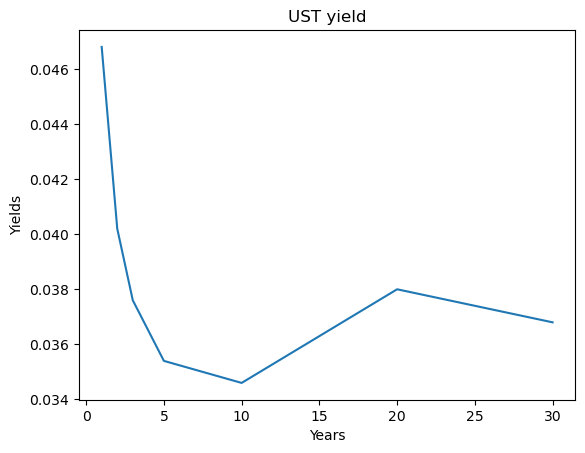

In [19]:
plt.plot(maturity_year, yields)
plt.xlabel('Years')
plt.ylabel("Yields")
plt.title("UST yield")
plt.show()

Create corporate yield cruve (CB1Y to 30Y)

In [20]:
corp_series_ids = {"CB1Y":"HQMCB1YR", "CB2Y":"HQMCB2YR", "CB3Y":"HQMCB3YR", "CB5Y":"HQMCB5YR","CB10Y":"HQMCB10YR", "CB20Y":"HQMCB20YR", "CB30Y":"HQMCB30YR"}
corp_yields = {}
for corp_yield, series_id in corp_series_ids.items():
    data = fred.get_series(series_id)
    corp_yields[corp_yield] = data[-1]/100

Text(0.5, 1.0, 'Corp yield')

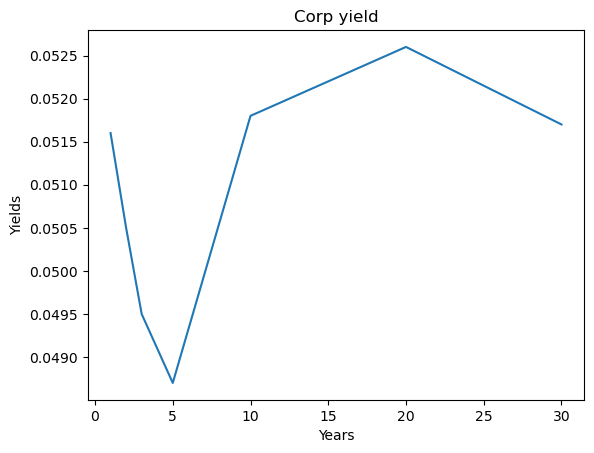

In [21]:
CB_maturities = list(corp_yields.keys())
CB_yields = list(corp_yields.values())
CB_maturity_year = [int(maturity[2:-1])for maturity in CB_maturities]
plt.plot(CB_maturity_year, CB_yields)
plt.xlabel('Years')
plt.ylabel("Yields")
plt.title('Corp yield')

Combine UST and CB yields

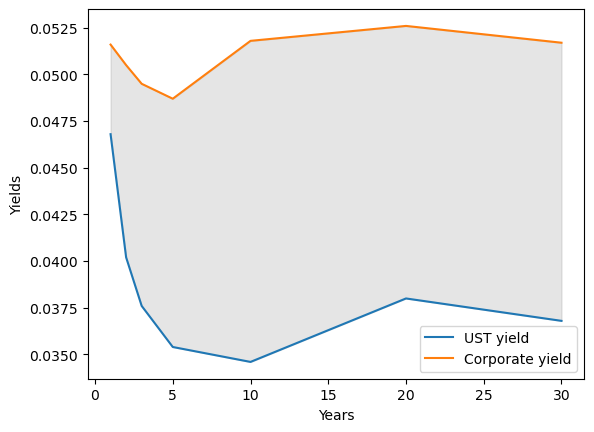

In [22]:
plt.plot(maturity_year, yields, label = "UST yield")
plt.plot(CB_maturity_year, CB_yields, label = "Corporate yield")
plt.xlabel('Years')
plt.ylabel("Yields")
plt.fill_between(maturity_year,yields, CB_yields,color = 'grey', alpha = 0.2)
plt.legend()
plt.show()

Calculate forward curve

In [23]:
forward_rates = [yields[0]]
for i in range(1, len(yields)):
    fwd_1 = ((1+yields[i])**maturity_year[i])/ ((1+yields[i-1])**maturity_year[i-1])
    fwd_2 = np.exp( np.log(fwd_1) / (maturity_year[i]-maturity_year[i-1]) ) -1
    forward_rates.append(fwd_2)
print(forward_rates)
print(yields)
print(len(maturity_year))

[0.046799999999999994, 0.03364161253343534, 0.03241948000696948, 0.03210874305342104, 0.033800618118601466, 0.04141117340034817, 0.03440416024591508]
[0.046799999999999994, 0.04019999999999999, 0.037599999999999995, 0.0354, 0.0346, 0.038, 0.0368]
7


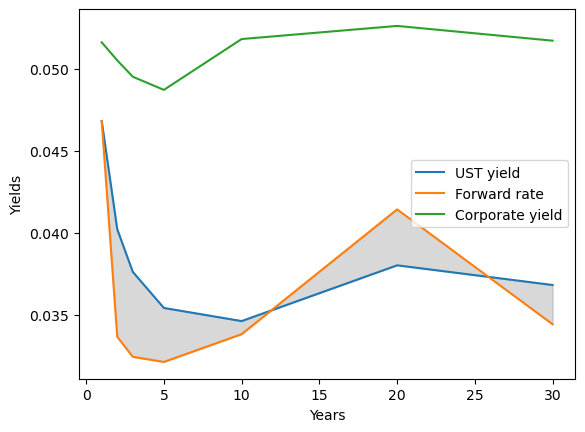

In [24]:
plt.plot(maturity_year, yields, label = "UST yield")
plt.plot(maturity_year, forward_rates, label = "Forward rate")
plt.plot(maturity_year, CB_yields, label = "Corporate yield")
plt.xlabel('Years')
plt.ylabel("Yields")
plt.fill_between(maturity_year,yields, forward_rates, color = 'grey', alpha = 0.3)
plt.legend()
plt.show()

*Yield curve fitting with Nelson Siegel*

In [25]:
#def YC_fitting(beta1, beta2, beta3, lambda4):

## Historical yields analysis

Getting historical yields from FRED API

In [26]:
from datetime import datetime

In [27]:
import pandas as pd
start_date = datetime(2000,1,1)
csv_files = ["GS1.csv", "GS2.csv", "GS3.csv", "GS5.csv", "GS10.csv", "GS20.csv", "GS30.csv"]
dfs = [pd.read_csv(file) for file in csv_files]
combined_df = dfs[0]
for df in dfs[1:]:
    combined_df = pd.merge(combined_df, df, on='DATE')
combined_df.to_csv('combined.csv', index = False)
print(combined_df)

           DATE   GS1   GS2   GS3   GS5  GS10  GS20  GS30
0    2000-01-01  6.12  6.44  6.49  6.58  6.66  6.86  6.63
1    2000-02-01  6.22  6.61  6.65  6.68  6.52  6.54  6.23
2    2000-03-01  6.22  6.53  6.53  6.50  6.26  6.38  6.05
3    2000-04-01  6.15  6.40  6.36  6.26  5.99  6.18  5.85
4    2000-05-01  6.33  6.81  6.77  6.69  6.44  6.55  6.15
..          ...   ...   ...   ...   ...   ...   ...   ...
275  2022-12-01  4.68  4.29  4.05  3.76  3.62  3.87  3.66
276  2023-01-01  4.69  4.21  3.91  3.64  3.53  3.81  3.66
277  2023-02-01  4.93  4.53  4.23  3.94  3.75  3.95  3.80
278  2023-03-01  4.68  4.30  4.09  3.82  3.66  3.94  3.77
279  2023-04-01  4.68  4.02  3.76  3.54  3.46  3.80  3.68

[280 rows x 8 columns]


In [28]:
import pandas as pd
df = combined_df
column_names = {"DATE": "Date", "GS1": "US1Y", "GS2": "US2Y", "GS3": "US3Y", "GS5": "US5Y", "GS10": "US10Y", "GS20": "US20Y", "GS30": "US30Y"}
df = df.rename(columns=column_names)
df["Date"] = pd.to_datetime(df["Date"])
df["Days"] = (df["Date"] - pd.Timestamp(df["Date"][0])).dt.days
df = df[["Date", "Days", "US1Y", "US2Y", "US3Y", "US5Y", "US10Y", "US20Y", "US30Y"]]
print(df)

          Date  Days  US1Y  US2Y  US3Y  US5Y  US10Y  US20Y  US30Y
0   2000-01-01     0  6.12  6.44  6.49  6.58   6.66   6.86   6.63
1   2000-02-01    31  6.22  6.61  6.65  6.68   6.52   6.54   6.23
2   2000-03-01    60  6.22  6.53  6.53  6.50   6.26   6.38   6.05
3   2000-04-01    91  6.15  6.40  6.36  6.26   5.99   6.18   5.85
4   2000-05-01   121  6.33  6.81  6.77  6.69   6.44   6.55   6.15
..         ...   ...   ...   ...   ...   ...    ...    ...    ...
275 2022-12-01  8370  4.68  4.29  4.05  3.76   3.62   3.87   3.66
276 2023-01-01  8401  4.69  4.21  3.91  3.64   3.53   3.81   3.66
277 2023-02-01  8432  4.93  4.53  4.23  3.94   3.75   3.95   3.80
278 2023-03-01  8460  4.68  4.30  4.09  3.82   3.66   3.94   3.77
279 2023-04-01  8491  4.68  4.02  3.76  3.54   3.46   3.80   3.68

[280 rows x 9 columns]


Plotting YCs in linear regression plots with seaborn

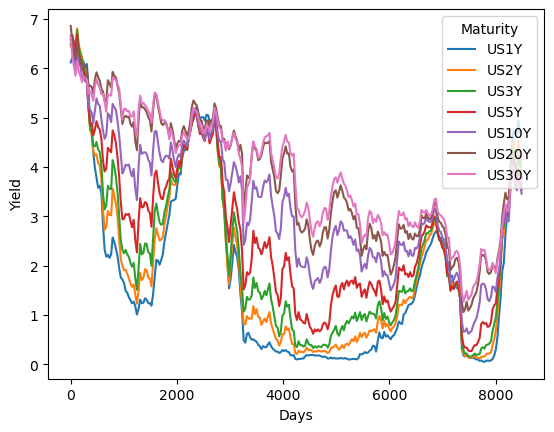

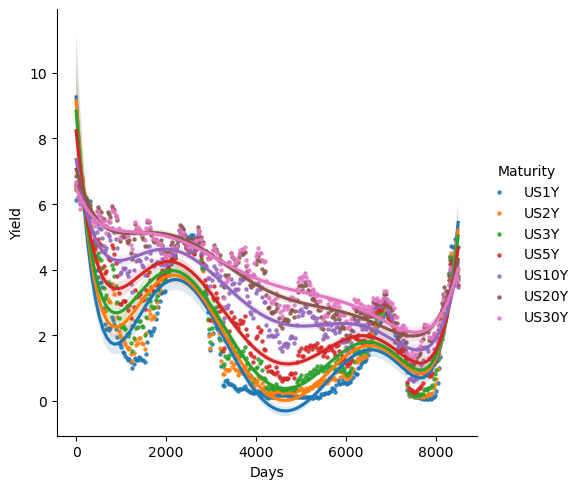

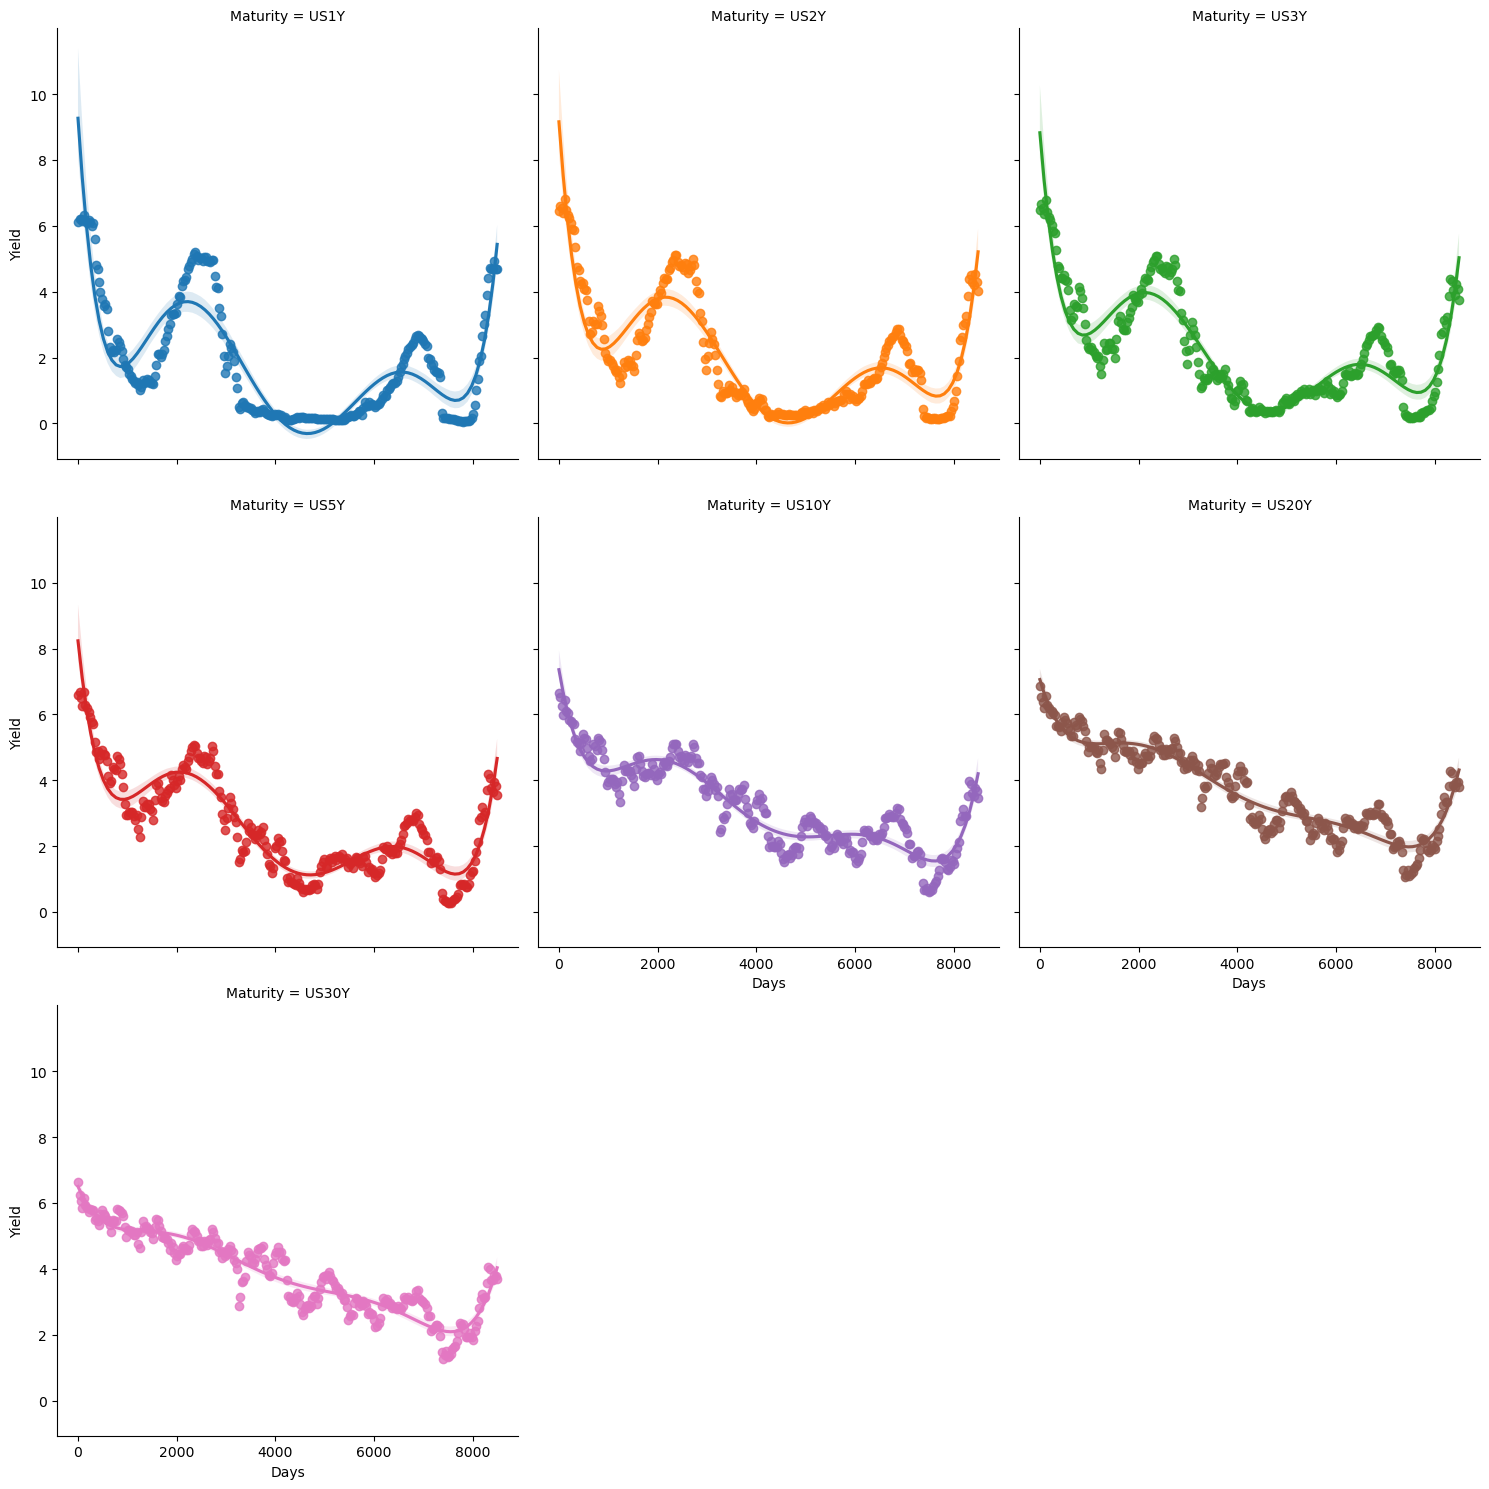

In [30]:
df_melted = df.melt(id_vars=['Date', "Days"], var_name='Maturity', value_name='Yield')
df_melted['Date'] = pd.to_datetime(df_melted['Date'])
df_melted['Days'] = (df_melted['Date'] - pd.Timestamp(start_date)).dt.days
ax1 = sns.lineplot(x = "Days", y = "Yield", hue = 'Maturity',data = df_melted)
ax2 = sns.lmplot (x = "Days", y = "Yield", hue = 'Maturity',scatter_kws={"s":5},data = df_melted,order = 6)
ax3 = sns.lmplot (x = "Days", y = "Yield", hue = 'Maturity',col = 'Maturity',col_wrap=3,data = df_melted, order = 6)

Yield curve correlation analytics

<AxesSubplot:>

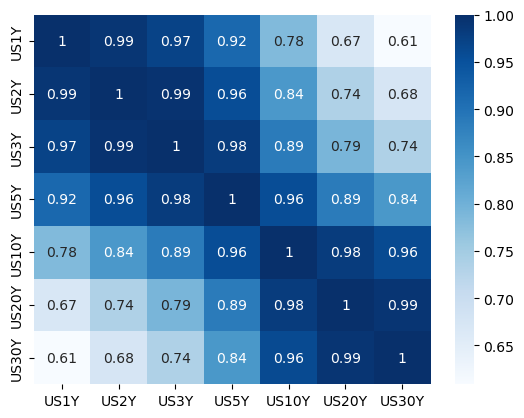

In [31]:
df_correlation_map = df.drop('Days', axis = 1)
sns.heatmap(df_correlation_map.corr(),cmap='Blues', annot= True)

## ML regression analysis (the fun begins!)

Import Sci-kit and XGboost

In [32]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance

In [33]:
print(df)
df.iloc[:,3]

          Date  Days  US1Y  US2Y  US3Y  US5Y  US10Y  US20Y  US30Y
0   2000-01-01     0  6.12  6.44  6.49  6.58   6.66   6.86   6.63
1   2000-02-01    31  6.22  6.61  6.65  6.68   6.52   6.54   6.23
2   2000-03-01    60  6.22  6.53  6.53  6.50   6.26   6.38   6.05
3   2000-04-01    91  6.15  6.40  6.36  6.26   5.99   6.18   5.85
4   2000-05-01   121  6.33  6.81  6.77  6.69   6.44   6.55   6.15
..         ...   ...   ...   ...   ...   ...    ...    ...    ...
275 2022-12-01  8370  4.68  4.29  4.05  3.76   3.62   3.87   3.66
276 2023-01-01  8401  4.69  4.21  3.91  3.64   3.53   3.81   3.66
277 2023-02-01  8432  4.93  4.53  4.23  3.94   3.75   3.95   3.80
278 2023-03-01  8460  4.68  4.30  4.09  3.82   3.66   3.94   3.77
279 2023-04-01  8491  4.68  4.02  3.76  3.54   3.46   3.80   3.68

[280 rows x 9 columns]


0      6.44
1      6.61
2      6.53
3      6.40
4      6.81
       ... 
275    4.29
276    4.21
277    4.53
278    4.30
279    4.02
Name: US2Y, Length: 280, dtype: float64

### Linear regression

In [34]:
x_trial = df[["US1Y", "US2Y", "US3Y", "US5Y", "US10Y", "US20Y", "Days"]]
y_trial = df["US30Y"]
x_train, x_test, y_train, y_test = train_test_split(x_trial, y_trial, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
mse_lr = mean_squared_error(y_test, y_pred)
print(mse_lr)

0.011171907940213253


Loop through different maturities and find the best linear prediction model (with least MSE and max R^2)

US1Y, MSE = 0.010359606736190963, r^2 = 0.9966451504399364
4.465260023307639
US2Y, MSE = 0.0008104418056020082, r^2 = 0.9997092684128414
1.2112795794672457
US3Y, MSE = 0.0005180271230708738, r^2 = 0.999795722030036
0.9495746583575273
US5Y, MSE = 0.0016907298480076682, r^2 = 0.9992240163188313
1.7640940289269653
US10Y, MSE = 0.003482289677559256, r^2 = 0.9979734978037454
2.802926784819298
US20Y, MSE = 0.009631354603650399, r^2 = 0.9944334259383198
4.367101329128067
US30Y, MSE = 0.011171907940239326, r^2 = 0.992230984167289
3.9827259237618957
Min MSE = US3Y, Max R^2 = US3Y
Int64Index([ 33, 108, 240, 259, 154,   9, 146, 203, 144, 155, 221,  92, 222,
            209,  42, 210,  66,  90, 119, 142, 262, 268, 206, 238,  46,  77,
             68,  75, 216, 277,  45, 111,  60, 217, 143,  30,  22,  24, 127,
            176,  79, 264, 237, 120, 196, 245, 168,   6, 239,  73,  84,  56,
             25,  97, 147,  19],
           dtype='int64')


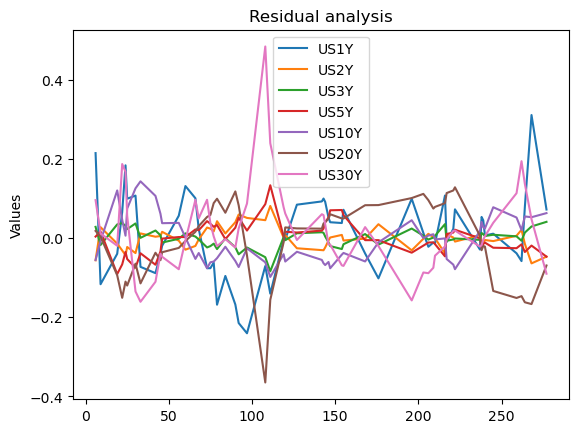

In [35]:
mse_dict = {}
r2_dict = {}
for i in range(2,len(df.columns)):
    x_drop = df.drop(columns=[df.columns[i], df.columns[0]])
    y = df[df.columns[i]]
    x_train, x_test, y_train, y_test = train_test_split(x_drop, y, test_size=0.2, random_state=42)
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)
    y_pred = lr_model.predict(x_test)
    mse_lr = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{df.columns[i]}, MSE = {mse_lr}, r^2 = {r2}")
    mse_dict[df.columns[i]] = mse_lr
    r2_dict[df.columns[i]] = r2
    residuals = y_pred - y_test
    sns.lineplot(x = y_test.index, y = residuals, label = f'{df.columns[i]}')
    print(residuals.abs().sum())
print(f"Min MSE = {min(mse_dict.items(), key=lambda x: x[1])[0]}, Max R^2 = {max(r2_dict.items(), key=lambda x: x[1])[0]}")
print(y_test.index)
plt.title("Residual analysis")
plt.ylabel("Values")
plt.show()

**Linear regression results on best prediction**

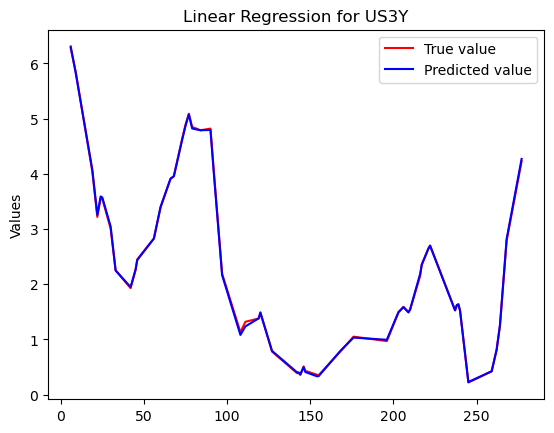

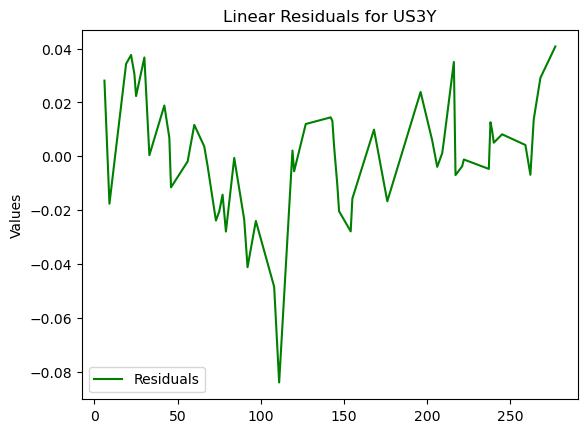

In [36]:
y = df[min(mse_dict.items(), key=lambda x: x[1])[0]]
x = df.drop(columns = [df.columns[0],min(mse_dict.items(), key=lambda x: x[1])[0]])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
ax_reg1 = sns.lineplot(x = y_test.index, y = y_test, color = 'red', label = "True value")
ax_reg2 = sns.lineplot(x = y_test.index, y = y_pred, color = 'blue', label = "Predicted value")
plt.title(f"Linear Regression for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()
linear_residuals = y_pred - y_test
ax_reg3 = sns.lineplot(x = y_test.index, y = linear_residuals, color = 'green', label = "Residuals")
plt.title(f"Linear Residuals for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()

### XGB Regression

Loop through different maturities and find the prediction model (with least MSE and max R^2)

US1Y, MSE = 0.01102226872273476, r^2 = 0.9964305543330918
4.133862946629522
US2Y, MSE = 0.003403678945762591, r^2 = 0.9987789906995914
2.214433419108392
US3Y, MSE = 0.004335166793322827, r^2 = 0.9982904774044542
2.6936635124683375
US5Y, MSE = 0.006415686211558496, r^2 = 0.9970554327117754
3.533553664684296
US10Y, MSE = 0.0038859559042908063, r^2 = 0.9977385861304585
2.7461782121658342
US20Y, MSE = 0.0034239757113805405, r^2 = 0.9980210660735542
2.466414027214052
US30Y, MSE = 0.0066688581535497915, r^2 = 0.9953624336274363
3.1721107959747314
Min MSE = US2Y, Max R^2 = US2Y


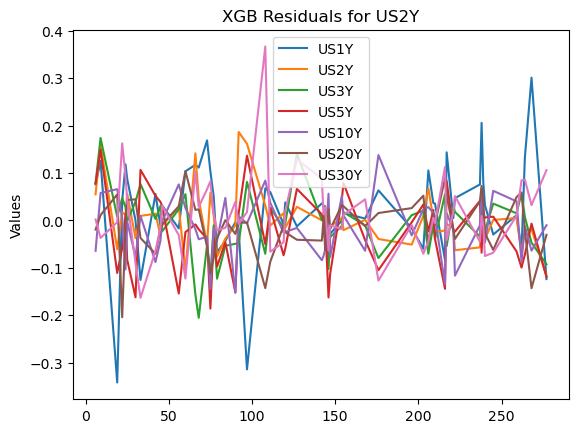

In [37]:
xgb_mse_dict = {}
xgb_r2_dict = {}
for i in range(2,len(df.columns)):
    x_drop = df.drop(columns=[df.columns[i], df.columns[0]])
    y = df[df.columns[i]]
    x_train, x_test, y_train, y_test = train_test_split(x_drop, y, test_size=0.2, random_state=42)
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.09, max_depth=6)
    xgb_model.fit(x_train, y_train)
    y_pred = xgb_model.predict(x_test)
    mse_lr = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{df.columns[i]}, MSE = {mse_lr}, r^2 = {r2}")
    mse_dict[df.columns[i]] = mse_lr
    r2_dict[df.columns[i]] = r2
    residuals = y_pred - y_test
    sns.lineplot(x = y_test.index, y = residuals, label = f'{df.columns[i]}')
    print(residuals.abs().sum())
print(f"Min MSE = {min(mse_dict.items(), key=lambda x: x[1])[0]}, Max R^2 = {max(r2_dict.items(), key=lambda x: x[1])[0]}")
plt.title(f"XGB Residuals for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()

XGB regression results on best prediction

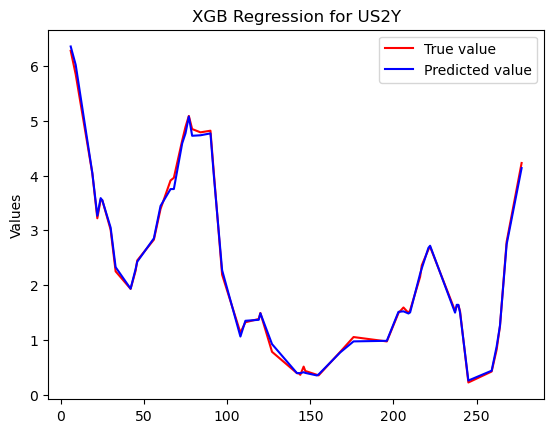

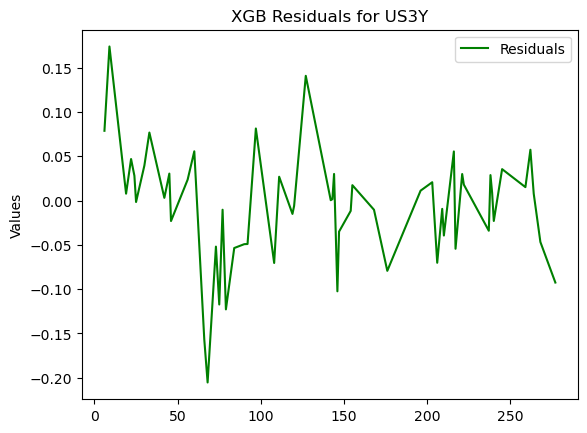

In [195]:
y = df["US3Y"]
x = df.drop(columns = [df.columns[0],"US3Y"])
x_train, x_test, y_train, y_test_xgb = train_test_split(x, y, test_size=0.2, random_state=42)
lr_model = XGBRegressor(n_estimators=100, learning_rate=0.09, max_depth=6)
lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
ax_reg1 = sns.lineplot(x = y_test_xgb.index, y = y_test_xgb, color = 'red', label = "True value")
ax_reg2 = sns.lineplot(x = y_test_xgb.index, y = y_pred, color = 'blue', label = "Predicted value")
plt.title(f"XGB Regression for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()
xgb_residuals = y_pred - y_test_xgb
ax_reg3 = sns.lineplot(x = y_test_xgb.index, y = xgb_residuals, color = 'green', label = "Residuals")
plt.title(f"XGB Residuals for US3Y")
plt.ylabel("Values")
plt.show()

Residuals comparison between Linear and XGB

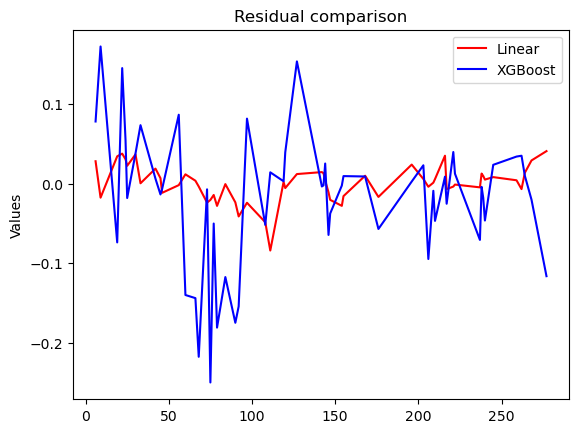

In [39]:
ax_reg4 = sns.lineplot(x = y_test.index, y = linear_residuals, color = 'Red', label = "Linear")
ax_xgb4 = sns.lineplot(x = y_test_xgb.index, y = xgb_residuals, color = 'Blue', label = "XGBoost")
plt.title("Residual comparison")
plt.ylabel("Values")
plt.show()

## Historical forward curves

In [127]:
historical_yields = df[["US1Y", 'US2Y', 'US3Y', 'US5Y', 'US10Y', 'US20Y', 'US30Y']].values
print(historical_yields)
historial_forwards = np.empty_like(historical_yields)
historial_forwards[:, 0] = historical_yields[:, 0]
for i in range(len(historical_yields)):
    for j in range(1, historical_yields.shape[1]):
            fwd_1 = ((1+historical_yields[i, j])**maturity_year[j])/ ((1+historical_yields[i, j-1])**maturity_year[j-1])
            fwd_2 = np.exp( np.log(fwd_1) / (maturity_year[j]-maturity_year[j-1]) ) -1
            historial_forwards[i, j] = fwd_2
print(historial_forwards)

[[6.12 6.44 6.49 ... 6.66 6.86 6.63]
 [6.22 6.61 6.65 ... 6.52 6.54 6.23]
 [6.22 6.53 6.53 ... 6.26 6.38 6.05]
 ...
 [4.93 4.53 4.23 ... 3.75 3.95 3.8 ]
 [4.68 4.3  4.09 ... 3.66 3.94 3.77]
 [4.68 4.02 3.76 ... 3.46 3.8  3.68]]
[[6.12       6.77438202 6.59101032 ... 6.74084433 7.06522193 6.1899939 ]
 [6.22       7.02106648 6.73063185 ... 6.36333333 6.56005319 5.64771206]
 [6.22       6.85331025 6.53       ... 6.02768    6.50198347 5.43360847]
 ...
 [4.93       4.15698145 3.67794169 ... 3.56730769 4.15842105 3.51349862]
 [4.68       3.94542254 3.69463257 ... 3.5053112  4.23682403 3.44734928]
 [4.68       3.43669014 3.27970096 ... 3.38140969 4.16591928 3.448925  ]]


In [146]:
histforward_cols = ["1f1", "2f1", "3f2", "5f5", "10f10", "20f10"]
fwds = pd.DataFrame(historial_forwards)
df_fwds = pd.concat([df, fwds], axis=1)
column_names = {0: "1f0", 1: "1f1", 2: "2f1", 3: "3f2", 4: "5f5", 5: "10f10", 6: "20f10"}
df_fwds = df_fwds.rename(columns=column_names)
print(df_fwds)


          Date  Days  US1Y  US2Y  US3Y  US5Y  US10Y  US20Y  US30Y   1f0  \
0   2000-01-01     0  6.12  6.44  6.49  6.58   6.66   6.86   6.63  6.12   
1   2000-02-01    31  6.22  6.61  6.65  6.68   6.52   6.54   6.23  6.22   
2   2000-03-01    60  6.22  6.53  6.53  6.50   6.26   6.38   6.05  6.22   
3   2000-04-01    91  6.15  6.40  6.36  6.26   5.99   6.18   5.85  6.15   
4   2000-05-01   121  6.33  6.81  6.77  6.69   6.44   6.55   6.15  6.33   
..         ...   ...   ...   ...   ...   ...    ...    ...    ...   ...   
275 2022-12-01  8370  4.68  4.29  4.05  3.76   3.62   3.87   3.66  4.68   
276 2023-01-01  8401  4.69  4.21  3.91  3.64   3.53   3.81   3.66  4.69   
277 2023-02-01  8432  4.93  4.53  4.23  3.94   3.75   3.95   3.80  4.93   
278 2023-03-01  8460  4.68  4.30  4.09  3.82   3.66   3.94   3.77  4.68   
279 2023-04-01  8491  4.68  4.02  3.76  3.54   3.46   3.80   3.68  4.68   

          1f1       2f1       3f2       5f5     10f10     20f10  
0    6.774382  6.591010  6.717032

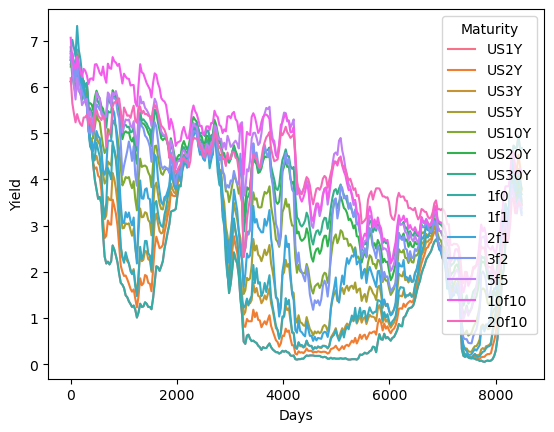

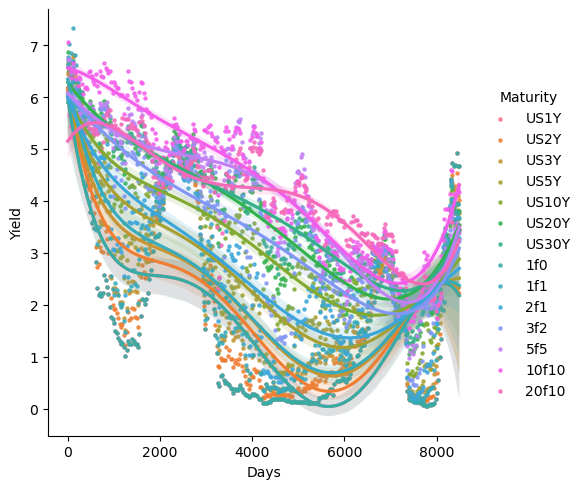

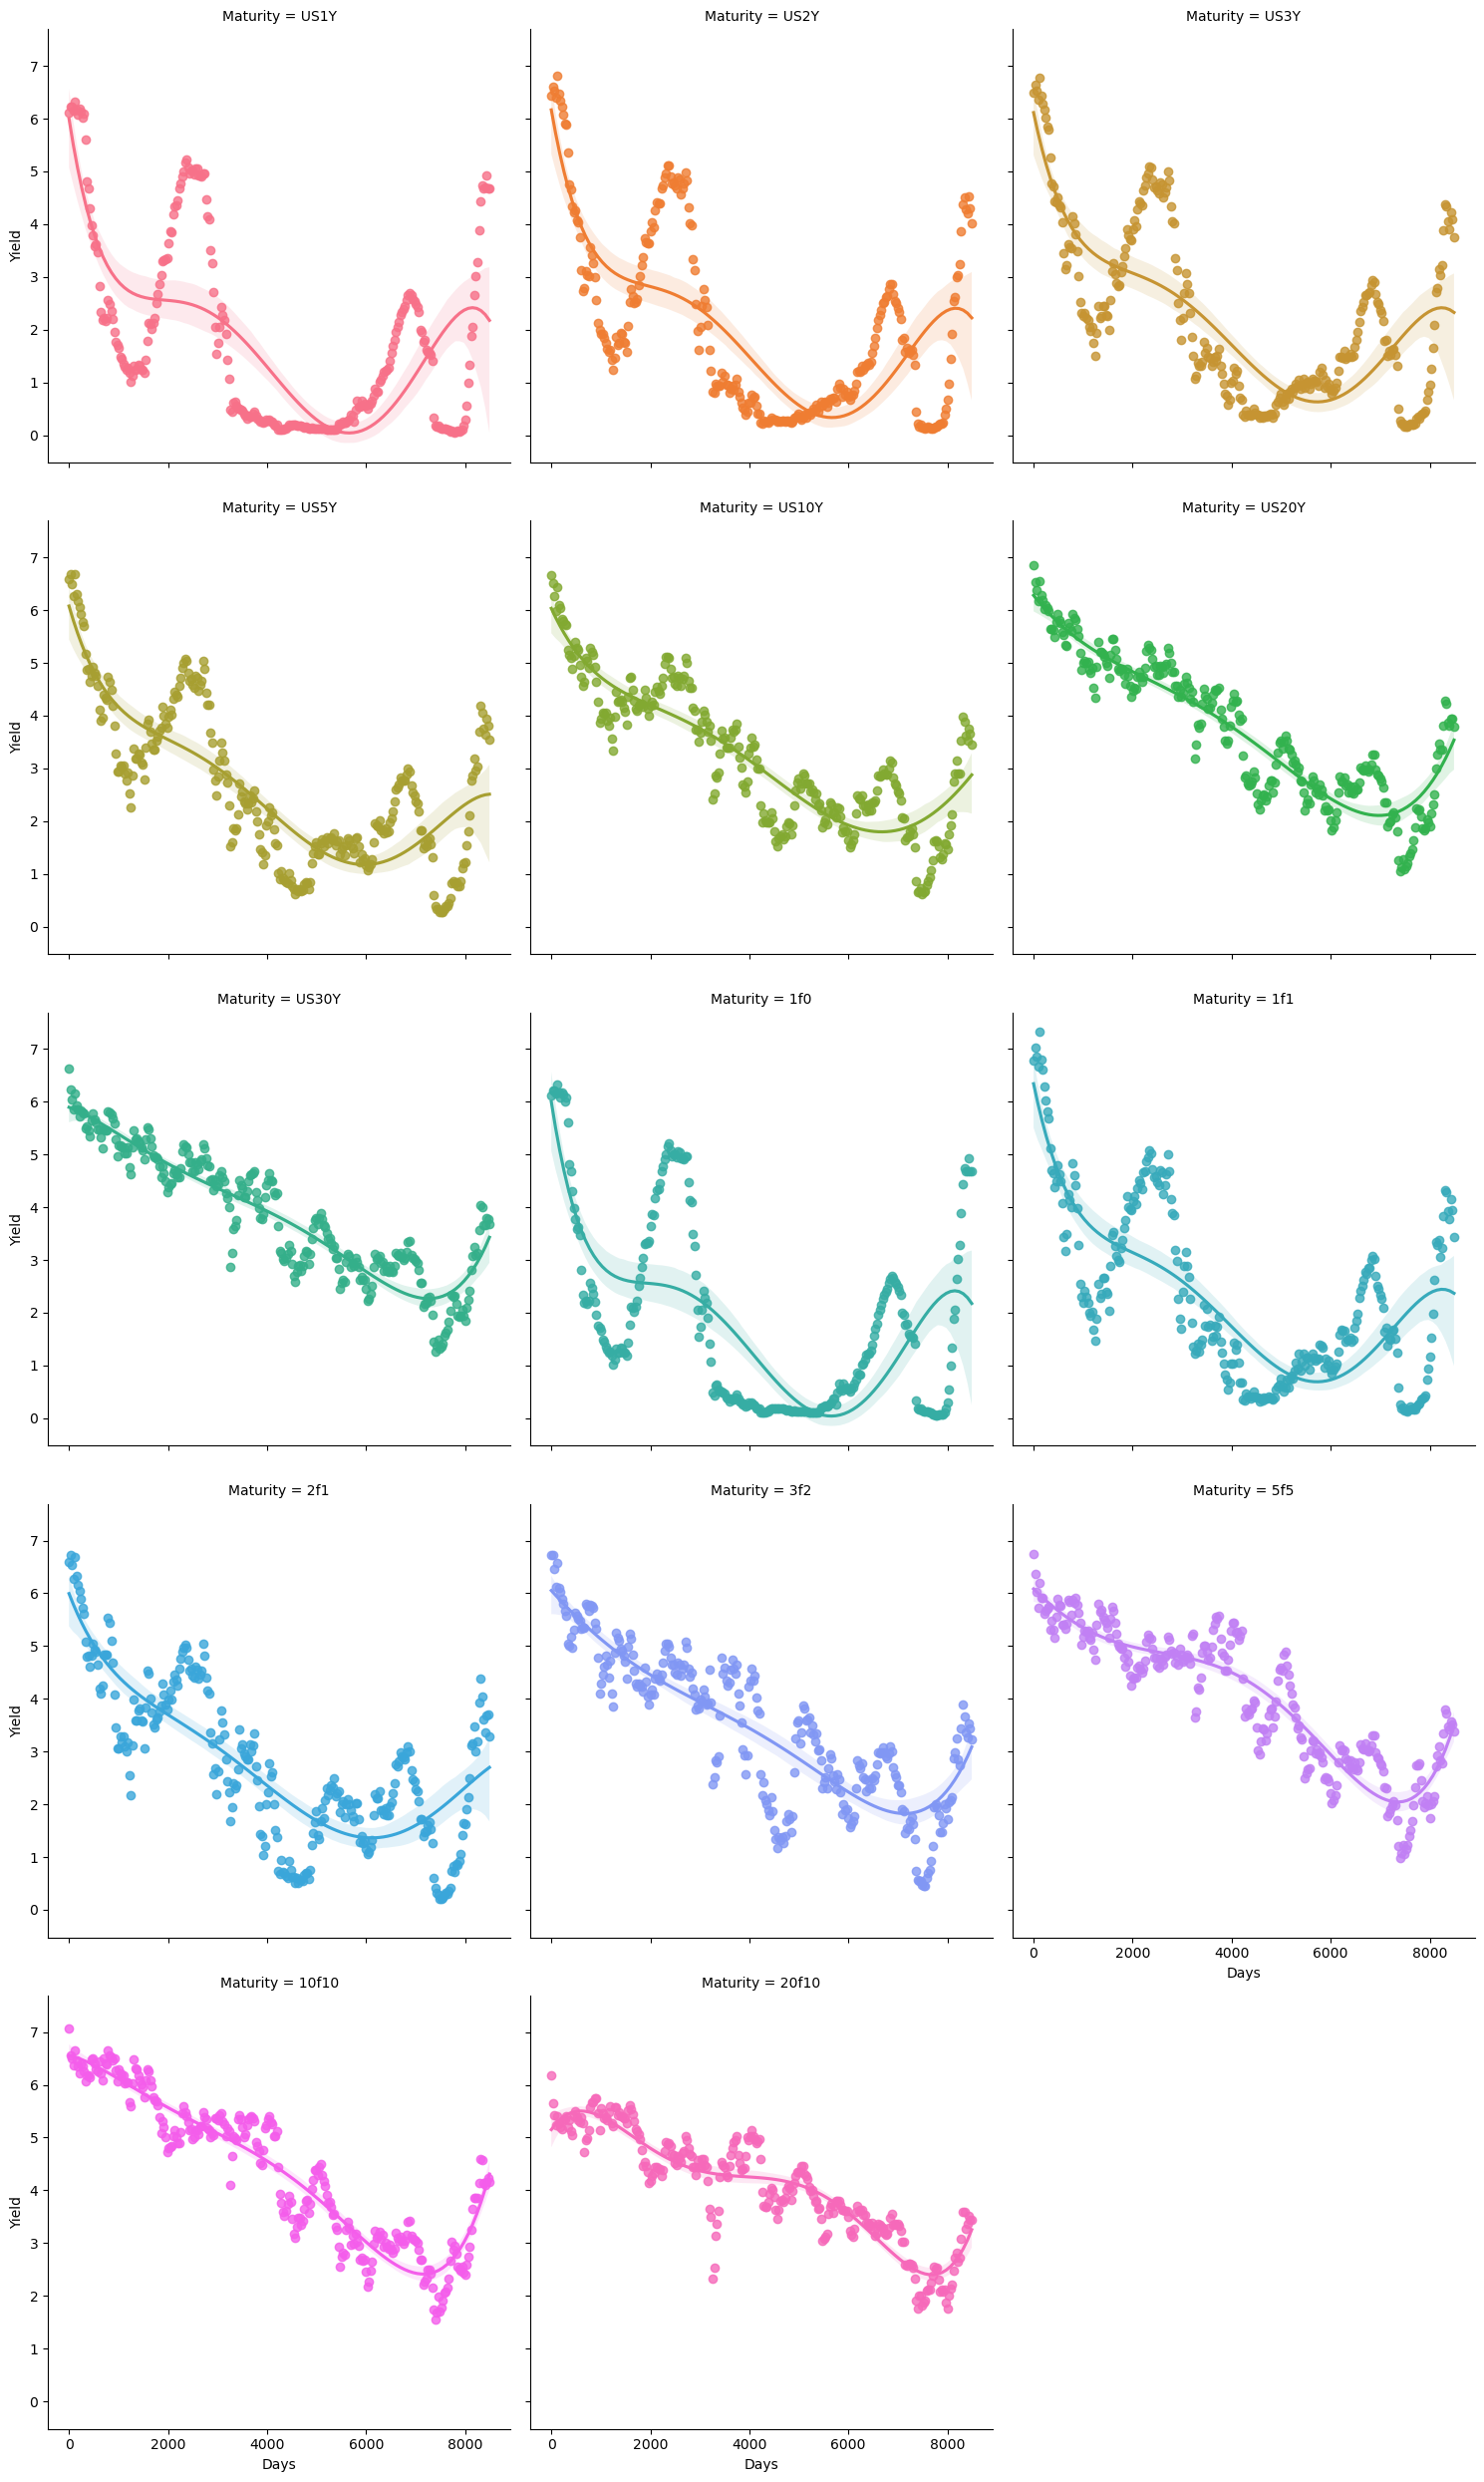

In [161]:
df_fwds_melted = df_fwds.melt(id_vars=['Date', "Days"], var_name='Maturity', value_name='Yield')
ax1_fwd = sns.lineplot(x = "Days", y = "Yield", hue = 'Maturity',data = df_fwds_melted )
ax2_fwd = sns.lmplot (x = "Days", y = "Yield", hue = 'Maturity',scatter_kws={"s":5},data = df_fwds_melted, order = 5)
ax3_fwd = sns.lmplot (x = "Days", y = "Yield", hue = 'Maturity',col = 'Maturity',col_wrap=3,data = df_fwds_melted, order = 5)

### Correlation analysis

<AxesSubplot:>

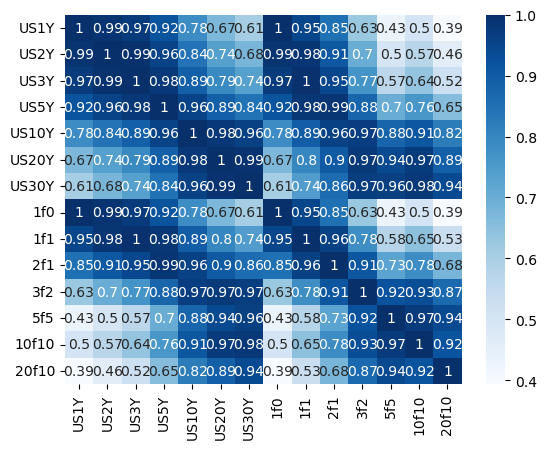

In [159]:
df_fwds_correlation_map = df_fwds.drop('Days', axis = 1)
sns.heatmap(df_fwds_correlation_map.corr(),cmap='Blues', annot= True)

## Forwards regression analysis

In [162]:
print(df_fwds)

          Date  Days  US1Y  US2Y  US3Y  US5Y  US10Y  US20Y  US30Y   1f0  \
0   2000-01-01     0  6.12  6.44  6.49  6.58   6.66   6.86   6.63  6.12   
1   2000-02-01    31  6.22  6.61  6.65  6.68   6.52   6.54   6.23  6.22   
2   2000-03-01    60  6.22  6.53  6.53  6.50   6.26   6.38   6.05  6.22   
3   2000-04-01    91  6.15  6.40  6.36  6.26   5.99   6.18   5.85  6.15   
4   2000-05-01   121  6.33  6.81  6.77  6.69   6.44   6.55   6.15  6.33   
..         ...   ...   ...   ...   ...   ...    ...    ...    ...   ...   
275 2022-12-01  8370  4.68  4.29  4.05  3.76   3.62   3.87   3.66  4.68   
276 2023-01-01  8401  4.69  4.21  3.91  3.64   3.53   3.81   3.66  4.69   
277 2023-02-01  8432  4.93  4.53  4.23  3.94   3.75   3.95   3.80  4.93   
278 2023-03-01  8460  4.68  4.30  4.09  3.82   3.66   3.94   3.77  4.68   
279 2023-04-01  8491  4.68  4.02  3.76  3.54   3.46   3.80   3.68  4.68   

          1f1       2f1       3f2       5f5     10f10     20f10  
0    6.774382  6.591010  6.717032

Tidy up forward table

In [181]:
cols_to_drop = df_fwds.columns[[0]]
col2_to_drop = df_fwds.columns[2:9]
df_only_fwds = df_fwds.drop(cols_to_drop, axis = 1)
df_only_fwds = df_only_fwds.drop(col2_to_drop, axis = 1)
print(df_only_fwds)

     Days   1f0       1f1       2f1       3f2       5f5     10f10     20f10
0       0  6.12  6.774382  6.591010  6.717032  6.740844  7.065222  6.189994
1      31  6.22  7.021066  6.730632  6.725221  6.363333  6.560053  5.647712
2      60  6.22  6.853310  6.530000  6.455224  6.027680  6.501983  5.433608
3      91  6.15  6.658741  6.280647  6.112542  5.730041  6.375165  5.234804
4     121  6.33  7.321432  6.690614  6.571542  6.198127  6.661626  5.412453
..    ...   ...       ...       ...       ...       ...       ...       ...
275  8370  4.68  3.926778  3.602171  3.355924  3.484118  4.133528  3.266776
276  8401  4.69  3.770492  3.360829  3.262582  3.422608  4.107307  3.373887
277  8432  4.93  4.156981  3.677942  3.534870  3.567308  4.158421  3.513499
278  8460  4.68  3.945423  3.694633  3.441615  3.505311  4.236824  3.447349
279  8491  4.68  3.436690  3.279701  3.228917  3.381410  4.165919  3.448925

[280 rows x 8 columns]


## Predict yield based on short term fwds (US2Y with 1f0, 1f1; US30Y with 1f0, ..., 20f10)

### Linear regression

Loop through to find best prediction combination

US2Y, MSE = 0.04807965158467902, r^2 = 0.9827522799063099
9.21765189594916
US3Y, MSE = 0.08526726453268803, r^2 = 0.966375846114267
12.530275476883283
US5Y, MSE = 0.37801258860490566, r^2 = 0.8265059315186327
29.71612142886339
US10Y, MSE = 0.34125574187528823, r^2 = 0.8014078165721505
27.76993810604753
US20Y, MSE = 0.1066476969662318, r^2 = 0.938361494504091
15.837315808496296
US30Y, MSE = 0.1715139201715989, r^2 = 0.8807281291189253
19.43088871154509
Min MSE = US2Y, Max R^2 = US2Y
Int64Index([ 33, 108, 240, 259, 154,   9, 146, 203, 144, 155, 221,  92, 222,
            209,  42, 210,  66,  90, 119, 142, 262, 268, 206, 238,  46,  77,
             68,  75, 216, 277,  45, 111,  60, 217, 143,  30,  22,  24, 127,
            176,  79, 264, 237, 120, 196, 245, 168,   6, 239,  73,  84,  56,
             25,  97, 147,  19],
           dtype='int64')


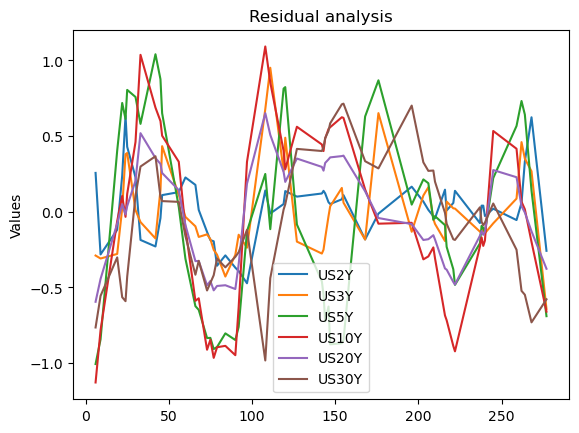

In [198]:
mse_dict = {}
r2_dict = {}
j = 2
for i in range(3,9):
    df_only_fwds_drop = df_only_fwds.columns[0:j]
    x_drop = df_only_fwds.drop(df_only_fwds_drop, axis = 1)
    y = df_fwds[df_fwds.columns[i]]
    x_train, x_test, y_train, y_test = train_test_split(x_drop, y, test_size=0.2, random_state=42)
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)
    y_pred = lr_model.predict(x_test)
    mse_lr = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{df_fwds.columns[i]}, MSE = {mse_lr}, r^2 = {r2}")
    mse_dict[df_fwds.columns[i]] = mse_lr
    r2_dict[df_fwds.columns[i]] = r2
    residuals = y_pred - y_test
    sns.lineplot(x = y_test.index, y = residuals, label = f'{df_fwds.columns[i]}')
    print(residuals.abs().sum())
    j += 1
print(f"Min MSE = {min(mse_dict.items(), key=lambda x: x[1])[0]}, Max R^2 = {max(r2_dict.items(), key=lambda x: x[1])[0]}")
print(y_test.index)
plt.title("Residual analysis")
plt.ylabel("Values")
plt.show()

Linear regression in US2Y

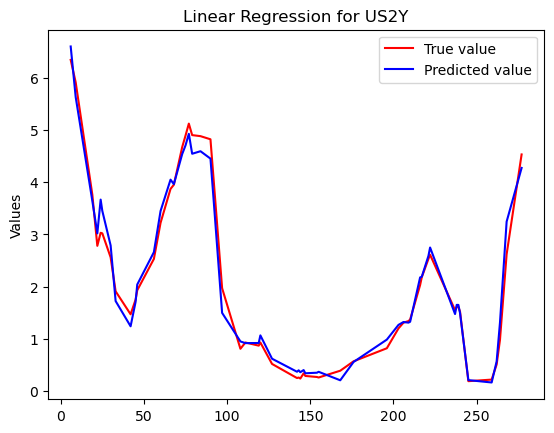

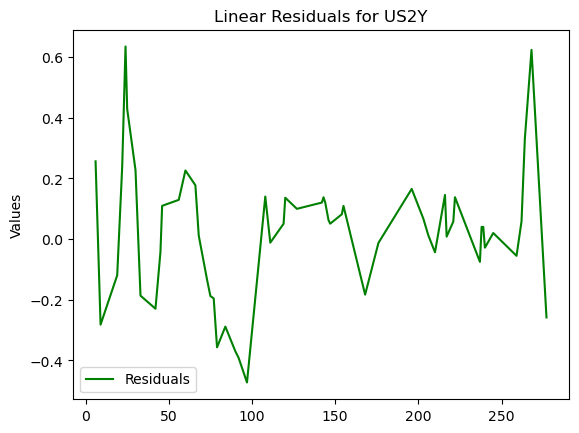

In [305]:
df_only_fwds_drop = df_only_fwds.columns[0:2]
x_drop = df_only_fwds.drop(df_only_fwds_drop, axis = 1)
y = df_fwds[df_fwds.columns[3]]
x_train, x_test, y_train, y_test_lr = train_test_split(x_drop, y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
ax_reg1 = sns.lineplot(x = y_test_lr.index, y = y_test_lr, color = 'red', label = "True value")
ax_reg2 = sns.lineplot(x = y_test_lr.index, y = y_pred, color = 'blue', label = "Predicted value")
plt.title(f"Linear Regression for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()
lr_residuals = y_pred - y_test_lr
ax3 = sns.lineplot(x = y_test_lr.index, y = lr_residuals, color = 'green', label = "Residuals")
plt.title(f"Linear Residuals for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()

## XGBoost

US2Y, MSE = 0.03241649248646206, r^2 = 0.9883711597235477
6.7153340291976935
US3Y, MSE = 0.06019996464171651, r^2 = 0.9762608442275901
9.50518246293068
US5Y, MSE = 0.13300665921386318, r^2 = 0.9389547672809212
14.786712864637376
US10Y, MSE = 0.1582952906629426, r^2 = 0.9078807957154075
16.905689492225648
US20Y, MSE = 0.053344272699123105, r^2 = 0.9691689427950678
10.173603324890136
US30Y, MSE = 0.20285412966649913, r^2 = 0.8589339481187959
18.676039085388183
Min MSE = US2Y, Max R^2 = US2Y
Int64Index([ 33, 108, 240, 259, 154,   9, 146, 203, 144, 155, 221,  92, 222,
            209,  42, 210,  66,  90, 119, 142, 262, 268, 206, 238,  46,  77,
             68,  75, 216, 277,  45, 111,  60, 217, 143,  30,  22,  24, 127,
            176,  79, 264, 237, 120, 196, 245, 168,   6, 239,  73,  84,  56,
             25,  97, 147,  19],
           dtype='int64')


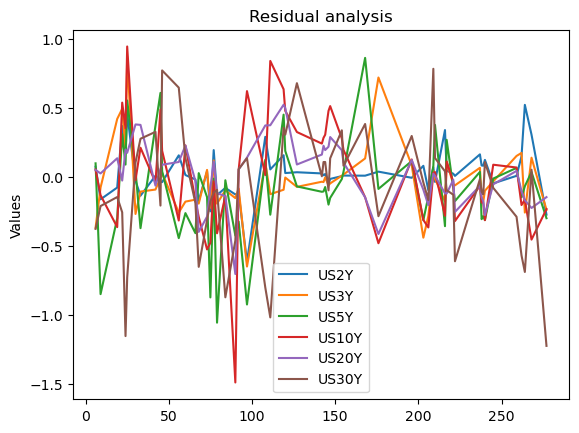

In [290]:
mse_dict = {}
r2_dict = {}
j = 2
for i in range(3,9):
    df_only_fwds_drop = df_only_fwds.columns[0:j]
    x_drop = df_only_fwds.drop(df_only_fwds_drop, axis = 1)
    y = df_fwds[df_fwds.columns[i]]
    x_train, x_test, y_train, y_test = train_test_split(x_drop, y, test_size=0.2, random_state=42)
    xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.08, max_depth=6)
    xgb_model.fit(x_train, y_train)
    y_pred = xgb_model.predict(x_test)
    mse_lr = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{df_fwds.columns[i]}, MSE = {mse_lr}, r^2 = {r2}")
    mse_dict[df_fwds.columns[i]] = mse_lr
    r2_dict[df_fwds.columns[i]] = r2
    residuals = y_pred - y_test
    sns.lineplot(x = y_test.index, y = residuals, label = f'{df_fwds.columns[i]}')
    print(residuals.abs().sum())
    j += 1
print(f"Min MSE = {min(mse_dict.items(), key=lambda x: x[1])[0]}, Max R^2 = {max(r2_dict.items(), key=lambda x: x[1])[0]}")
print(y_test.index)
plt.title("Residual analysis")
plt.ylabel("Values")
plt.show()

XGB in US2Y

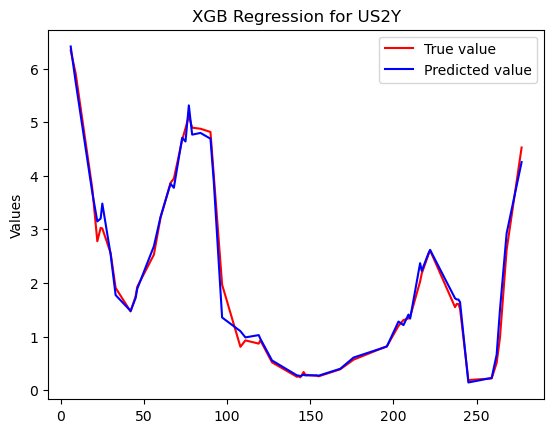

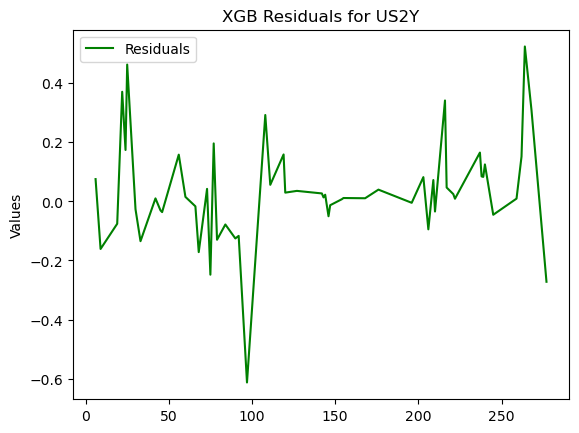

In [299]:
df_only_fwds_drop = df_only_fwds.columns[0:2]
x_drop = df_only_fwds.drop(df_only_fwds_drop, axis = 1)
y = df_fwds[df_fwds.columns[3]]
x_train, x_test, y_train, y_test_xgb = train_test_split(x_drop, y, test_size=0.2, random_state=42)
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.08, max_depth=6)
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
ax_reg1 = sns.lineplot(x = y_test_xgb.index, y = y_test_xgb, color = 'red', label = "True value")
ax_reg2 = sns.lineplot(x = y_test_xgb.index, y = y_pred, color = 'blue', label = "Predicted value")
plt.title(f"XGB Regression for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()
xgb_residuals = y_pred - y_test_xgb
ax = sns.lineplot(x = y_test_xgb.index, y = xgb_residuals, color = 'green', label = "Residuals")
plt.title(f"XGB Residuals for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()

### Gradient Boosting (US2Y)

US2Y, MSE = 0.03477632834869374, r^2 = 0.9875246105686076
6.700619802686917
US3Y, MSE = 0.07908530737578924, r^2 = 0.9688136290066557
9.9088662109933
US5Y, MSE = 0.27958704898683934, r^2 = 0.871679684524674
17.33246731801414
US10Y, MSE = 0.14929735419216503, r^2 = 0.9131171027743223
16.55804976168821
US20Y, MSE = 0.05875567714842158, r^2 = 0.9660413470534149
9.95724392302371
US30Y, MSE = 0.20323137875869252, r^2 = 0.8586716067008568
18.60767218880008
Min MSE = US2Y, Max R^2 = US2Y
Int64Index([ 33, 108, 240, 259, 154,   9, 146, 203, 144, 155, 221,  92, 222,
            209,  42, 210,  66,  90, 119, 142, 262, 268, 206, 238,  46,  77,
             68,  75, 216, 277,  45, 111,  60, 217, 143,  30,  22,  24, 127,
            176,  79, 264, 237, 120, 196, 245, 168,   6, 239,  73,  84,  56,
             25,  97, 147,  19],
           dtype='int64')


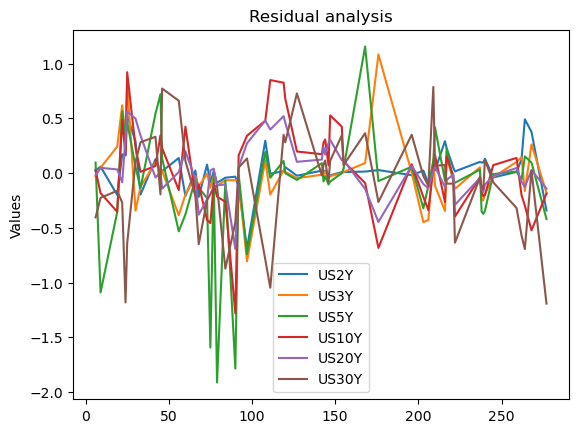

In [285]:
mse_dict = {}
r2_dict = {}
j = 2
for i in range(3,9):
    df_only_fwds_drop = df_only_fwds.columns[0:j]
    x_drop = df_only_fwds.drop(df_only_fwds_drop, axis = 1)
    y = df_fwds[df_fwds.columns[i]]
    x_train, x_test, y_train, y_test = train_test_split(x_drop, y, test_size=0.2, random_state=42)
    lr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0)
    lr_model.fit(x_train, y_train)
    y_pred = lr_model.predict(x_test)
    mse_lr = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{df_fwds.columns[i]}, MSE = {mse_lr}, r^2 = {r2}")
    mse_dict[df_fwds.columns[i]] = mse_lr
    r2_dict[df_fwds.columns[i]] = r2
    residuals = y_pred - y_test
    sns.lineplot(x = y_test.index, y = residuals, label = f'{df_fwds.columns[i]}')
    print(residuals.abs().sum())
    j += 1
print(f"Min MSE = {min(mse_dict.items(), key=lambda x: x[1])[0]}, Max R^2 = {max(r2_dict.items(), key=lambda x: x[1])[0]}")
print(y_test.index)
plt.title("Residual analysis")
plt.ylabel("Values")
plt.show()

Gradient boosting in US2Y 

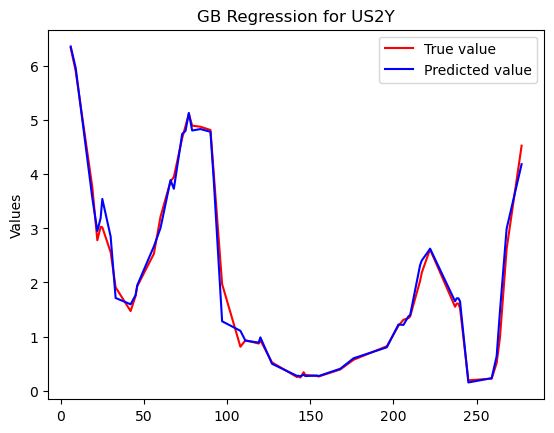

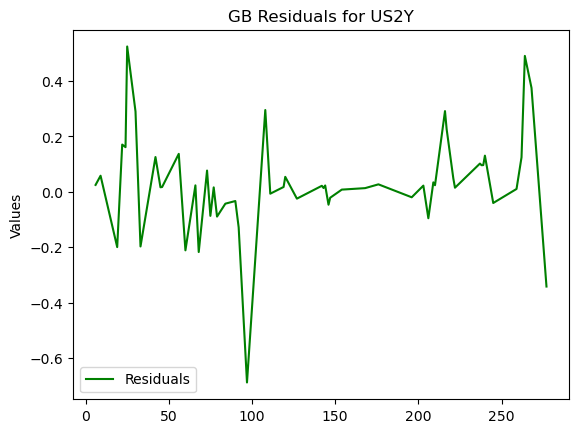

In [301]:
df_only_fwds_drop = df_only_fwds.columns[0:2]
x_drop = df_only_fwds.drop(df_only_fwds_drop, axis = 1)
y = df_fwds[df_fwds.columns[3]]
x_train, x_test, y_train, y_test_gb = train_test_split(x_drop, y, test_size=0.2, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0)
gb_model.fit(x_train, y_train)
y_pred = gb_model.predict(x_test)
ax_reg1 = sns.lineplot(x = y_test_gb.index, y = y_test_gb, color = 'red', label = "True value")
ax_reg2 = sns.lineplot(x = y_test_gb.index, y = y_pred, color = 'blue', label = "Predicted value")
plt.title(f"GB Regression for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()
gb_residuals = y_pred - y_test_gb
ax2 = sns.lineplot(x = y_test_gb.index, y = gb_residuals, color = 'green', label = "Residuals")
plt.title(f"GB Residuals for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()

### Residual analysis (US2Y)

<function matplotlib.pyplot.show(close=None, block=None)>

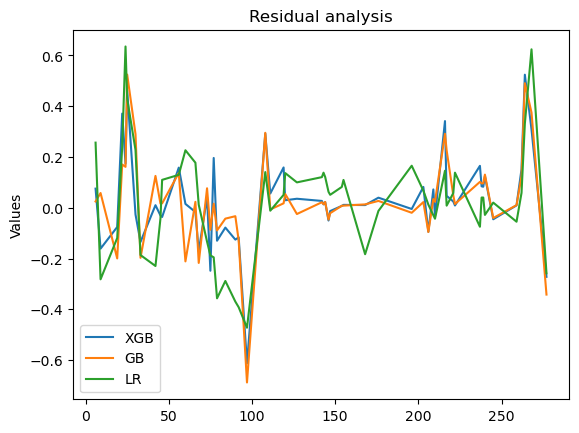

In [307]:
ax = sns.lineplot(x = y_test_xgb.index, y = xgb_residuals, label = "XGB")
ax2 = sns.lineplot(x = y_test_gb.index, y = gb_residuals, label = "GB")
ax3 = sns.lineplot(x = y_test_lr.index, y = lr_residuals, label = "LR")
plt.ylabel("Values")
plt.title("Residual analysis")
plt.show